In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from mtcnn import MTCNN

In [11]:
import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# Paths to videos
REAL_VIDEOS_PATH = # Path to real videos for training
FAKE_VIDEOS_PATH = # Path to fake videos for training

# Paths to save extracted frames
OUTPUT_REAL_FRAMES = # Path to save real frames for training
OUTPUT_FAKE_FRAMES = # Path to save fake frames for training

# Create directories if not exist
os.makedirs(OUTPUT_REAL_FRAMES, exist_ok=True)
os.makedirs(OUTPUT_FAKE_FRAMES, exist_ok=True)

In [ ]:
# Extract frames from videopath and save to outputfolder with frame_interval of 5 seconds
def extract_frames(video_path, output_folder, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = cap.read()

    while success:
        if frame_count % frame_interval == 0:  # Extract every nth frame
            frame_name = f"{os.path.basename(video_path).split('.')[0]}_frame{frame_count}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_name), frame)

        success, frame = cap.read()
        frame_count += 1

    cap.release()

In [ ]:
# Extract frames from REAL videos
for video_file in tqdm(glob.glob(os.path.join(REAL_VIDEOS_PATH, "*.mov"))):
    extract_frames(video_file, OUTPUT_REAL_FRAMES)

# Extract frames from FAKE videos
for video_file in tqdm(glob.glob(os.path.join(FAKE_VIDEOS_PATH, "*.avi"))):
    extract_frames(video_file, OUTPUT_FAKE_FRAMES)

print("Frame extraction completed!")

In [3]:
OUTPUT_REAL_FRAMES = (r"celebdf+ff++\train\real") # Path of saved real frames for training
OUTPUT_FAKE_FRAMES = (r"celebdf+ff++\train\fake") # Path of saved fake frames for training

In [4]:
print(f"Total Real Frames: {len(os.listdir(OUTPUT_REAL_FRAMES))}")
print(f"Total Fake Frames: {len(os.listdir(OUTPUT_FAKE_FRAMES))}")

Total Real Frames: 5605
Total Fake Frames: 6028


In [ ]:
IMG_SIZE = 128  # Resize images to 128x128 (change to 224x224 for deeper networks)
TRAIN_REAL_FRAMES_PATH = (r"celebdf+ff++\train\real")
TRAIN_FAKE_FRAMES_PATH = (r"celebdf+ff++\train\fake")
TEST_REAL_FRAMES_PATH = (r"celebdf+ff++\test\real")
TEST_FAKE_FRAMES_PATH = (r"celebdf+ff++\test\fake")

In [6]:
print(f"Total Train Real Frames: {len(os.listdir(TRAIN_REAL_FRAMES_PATH))}")
print(f"Total Train Fake Frames: {len(os.listdir(TRAIN_FAKE_FRAMES_PATH))}")
print(f"Total Test Real Frames: {len(os.listdir(TEST_REAL_FRAMES_PATH))}")
print(f"Total Test Fake Frames: {len(os.listdir(TEST_FAKE_FRAMES_PATH))}")

Total Train Real Frames: 5605
Total Train Fake Frames: 6028
Total Test Real Frames: 1200
Total Test Fake Frames: 1200


In [7]:
# Data Preprocessing
def load_images_from_folder(folder, label):
    images = []
    labels = []

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
        img = img / 255.0  # Normalize (0-1)
        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
''' # Load Real and Fake images and labels
train_real_images, train_real_labels = load_images_from_folder(TRAIN_REAL_FRAMES_PATH, label=0)  # 0 for Real
train_fake_images, train_fake_labels = load_images_from_folder(TRAIN_FAKE_FRAMES_PATH, label=1)  # 1 for Fake
test_real_images, test_real_labels = load_images_from_folder(TEST_REAL_FRAMES_PATH, label=0)  # 0 for Real
test_fake_images, test_fake_labels = load_images_from_folder(TEST_FAKE_FRAMES_PATH, label=1)  # 1 for Fake

# Combine and Shuffle Dataset
X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

# Shuffle data
X_train, y_train, X_test, y_test = shuffle(X_train, y_train, X_test, y_test ,random_state=42)


print(f"Training Data: {X_train.shape}, Trainimg labels: {y_train.shape}, Test Data : {X_test.shape}, Test labels : {y_test.shape}") '''

In [8]:
# Load Real and Fake images and labels
train_real_images, train_real_labels = load_images_from_folder(TRAIN_REAL_FRAMES_PATH, label=0)  # 0 for Real

In [9]:
train_fake_images, train_fake_labels = load_images_from_folder(TRAIN_FAKE_FRAMES_PATH, label=1)  # 1 for Fake

In [10]:
# Combine Dataset
X_train = np.concatenate((train_real_images, train_fake_images), axis=0)

In [11]:
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)

In [12]:
# deleted the no more needed variables to free up memory
del train_fake_images, train_fake_labels, train_real_images, train_real_labels

In [13]:
# Load Real images and labels
test_real_images, test_real_labels = load_images_from_folder(TEST_REAL_FRAMES_PATH, label=0)  # 0 for Real

In [14]:
test_fake_images, test_fake_labels = load_images_from_folder(TEST_FAKE_FRAMES_PATH, label=1)  # 1 for Fake

In [15]:
# Combine Dataset
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)

In [16]:
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

In [17]:
# deleted the no more needed variables to free up memory
del test_real_images, test_real_labels, test_fake_images, test_fake_labels

In [18]:
# deleted the no more needed variables to free up memory
del IMG_SIZE, TRAIN_REAL_FRAMES_PATH, TRAIN_FAKE_FRAMES_PATH, TEST_REAL_FRAMES_PATH, TEST_FAKE_FRAMES_PATH

In [19]:
# Shuffle data
X_train, y_train= shuffle(X_train, y_train,random_state=42)
X_test, y_test = shuffle(X_test, y_test ,random_state=42)

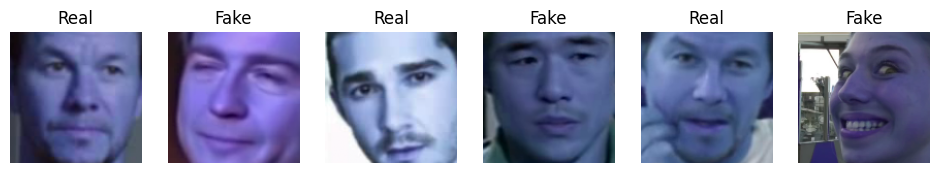

In [20]:
# Data Visualization (Real and Fake Images)
plt.figure(figsize=(20,20))
for i in range(4,10):
    plt.subplot(4,10,i+1)
    plt.imshow(X_train[i])
    plt.title("Fake" if y_train[i] == 1 else "Real")
    plt.axis("off")
plt.show()

In [ ]:
# Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile Model
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

In [ ]:
# Train Model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=16,
                    verbose=1)

In [ ]:
# Save model
model.save("deepfake_detector.h5")

In [ ]:
# Saved History for future use
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [2]:
# Loaded history from saved file
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Now `loaded_history` contains the training history

In [ ]:
# Detele the no more needed variables to free up memory
del X_train,X_test,y_train,y_test

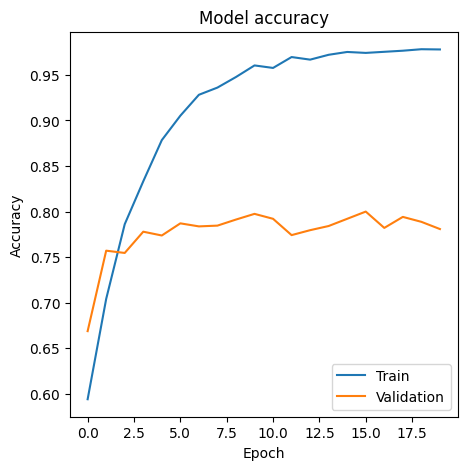

In [ ]:
# FIRST
# Plot training & validation accuracy values
plt.figure(figsize=(5,5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

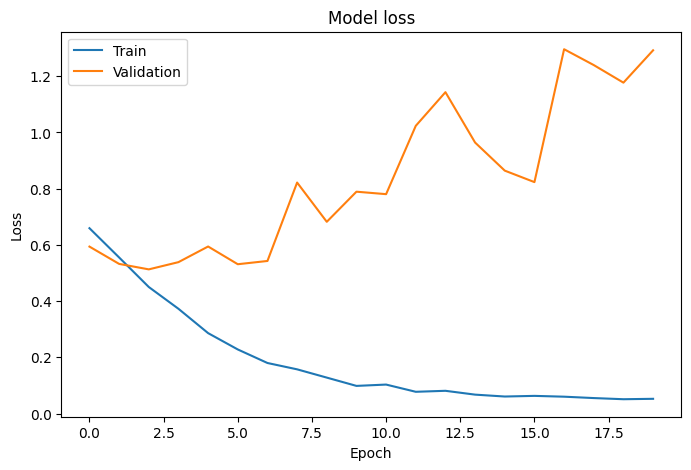

In [ ]:
# FIRST
# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Testing

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from mtcnn import MTCNN

In [2]:
# Load model
model = load_model("deepfake_detector.h5")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test = ImageDataGenerator(rescale=1./255).flow_from_directory(
    r"celebdf+ff++\test",
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary'
)

Found 2400 images belonging to 2 classes.


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


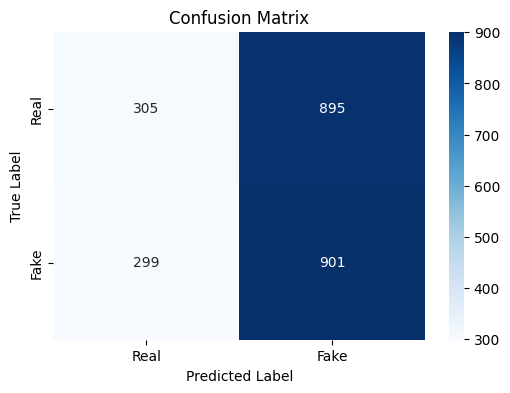

Classification Report:
               precision    recall  f1-score   support

        Real       0.50      0.25      0.34      1200
        Fake       0.50      0.75      0.60      1200

    accuracy                           0.50      2400
   macro avg       0.50      0.50      0.47      2400
weighted avg       0.50      0.50      0.47      2400



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get True Labels
true_labels = test.classes  # Actual labels from test data

# Predict Probabilities
pred_probs = model.predict(test)
pred_labels = (pred_probs > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Compute Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=["Real", "Fake"]))


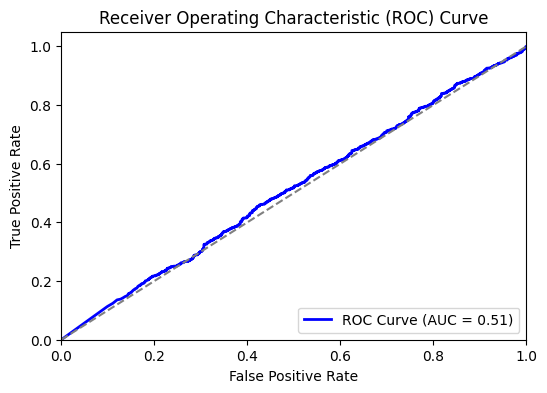

AUC Score: 0.5116


In [9]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.4f}")


In [8]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [13]:
train_generator = datagen.flow_from_directory(
    r"celebdf+ff++\train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    r"celebdf+ff++\validation",
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary'
)

Found 11633 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


In [20]:
early_stopping = EarlyStopping(monitor='val_loss',
            patience=3,
            verbose=1,
            mode='auto',
            restore_best_weights=True
            ),
model_checkpoint = ModelCheckpoint("best_model.h5", 
                save_best_only=True, 
                monitor="val_loss", 
                mode="min", 
                verbose=1
                )


In [22]:
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [23]:
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5096 - loss: 0.7972

c:\Users\jaiag\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.69616, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 124s 338ms/step - accuracy: 0.5096 - loss: 0.7969 - val_accuracy: 0.4646 - val_loss: 0.6962
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5237 - loss: 0.6824
Epoch 2: val_loss improved from 0.69616 to 0.69481, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 49s 133ms/step - accuracy: 0.5237 - loss: 0.6824 - val_accuracy: 0.5108 - val_loss: 0.6948
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5399 - loss: 0.6750
Epoch 3: val_loss improved from 0.69481 to 0.68381, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 54s 147ms/step - accuracy: 0.5399 - loss: 0.6750 - val_accuracy: 0.5942 - val_loss: 0.6838
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5626 - loss: 0.6653
Epoch 4: val_loss improved from 0.68381 to 0.63538, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.5627 - loss: 0.6653 - val_accuracy: 0.5967 - val_loss: 0.6354
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6024 - loss: 0.6500
Epoch 5: val_loss improved from 0.63538 to 0.53257, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.6024 - loss: 0.6500 - val_accuracy: 0.7358 - val_loss: 0.5326
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6459 - loss: 0.6271
Epoch 6: val_loss did not improve from 0.53257
364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.6459 - loss: 0.6271 - val_accuracy: 0.7225 - val_loss: 0.5390
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6818 - loss: 0.5929
Epoch 7: val_loss improved from 0.53257 to 0.51661, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - accuracy: 0.6818 - loss: 0.5929 - val_accuracy: 0.7367 - val_loss: 0.5166
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6988 - loss: 0.5747
Epoch 8: val_loss improved from 0.51661 to 0.50395, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - accuracy: 0.6988 - loss: 0.5747 - val_accuracy: 0.7354 - val_loss: 0.5039
Epoch 9/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7142 - loss: 0.5603
Epoch 9: val_loss improved from 0.50395 to 0.49533, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - accuracy: 0.7142 - loss: 0.5603 - val_accuracy: 0.7571 - val_loss: 0.4953
Epoch 10/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7378 - loss: 0.5429
Epoch 10: val_loss did not improve from 0.49533
364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.7378 - loss: 0.5429 - val_accuracy: 0.7433 - val_loss: 0.5919
Restoring model weights from the end of the best epoch: 9.


In [25]:
history1 = history1.history

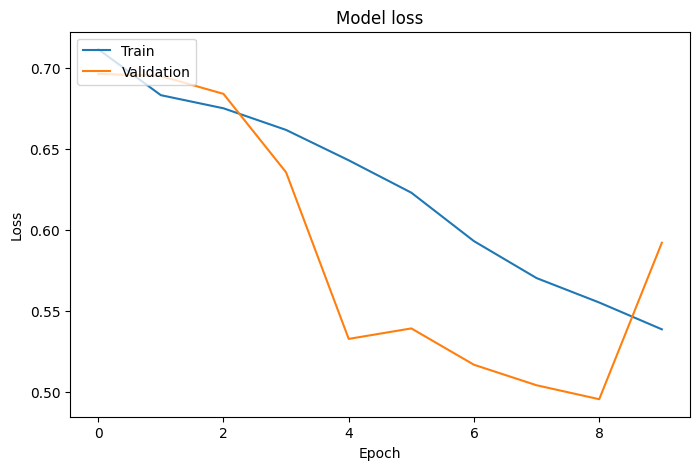

In [27]:
# FIRST
# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

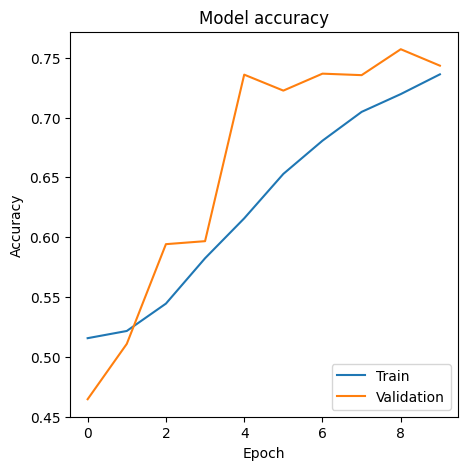

In [28]:
# FIRST
# Plot training & validation accuracy values
plt.figure(figsize=(5,5))
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [9]:
cap = cv2.VideoCapture(r"DeepfakeTIMIT\DeepfakeTIMIT\higher_quality\faks0\sa1-video-fedw0.avi")
frames = []
frame_interval = 5
frame_count = 0
ret = True
while ret:
    ret, frame = cap.read()
    if frame_count % frame_interval == 0:
        detector = MTCNN()
        faces = detector.detect_faces(frame)
        if len(faces) != 0:
            x, y, width, height = faces[0]['box']
            frame = frame[y:y + height, x:x + width]
            frame = cv2.resize(frame, (128, 128))
            frame = frame / 255.0  # Normalize
            frame = frame.astype(np.float32)
            frames.append(frame)
            print(faces)
    frame_count += 1

[{'box': [184, 111, 142, 183], 'confidence': np.float64(0.9998032450675964), 'keypoints': {'nose': [np.int64(260), np.int64(213)], 'mouth_right': [np.int64(286), np.int64(254)], 'right_eye': [np.int64(292), np.int64(182)], 'left_eye': [np.int64(225), np.int64(182)], 'mouth_left': [np.int64(233), np.int64(254)]}}]
[{'box': [185, 113, 143, 189], 'confidence': np.float64(0.9997479319572449), 'keypoints': {'nose': [np.int64(260), np.int64(213)], 'mouth_right': [np.int64(286), np.int64(256)], 'right_eye': [np.int64(292), np.int64(183)], 'left_eye': [np.int64(226), np.int64(183)], 'mouth_left': [np.int64(234), np.int64(256)]}}]
[{'box': [186, 112, 144, 190], 'confidence': np.float64(0.999401330947876), 'keypoints': {'nose': [np.int64(261), np.int64(215)], 'mouth_right': [np.int64(286), np.int64(256)], 'right_eye': [np.int64(293), np.int64(183)], 'left_eye': [np.int64(227), np.int64(183)], 'mouth_left': [np.int64(234), np.int64(255)]}}]
[{'box': [184, 110, 139, 182], 'confidence': np.float64(

In [10]:
len(frames)

18

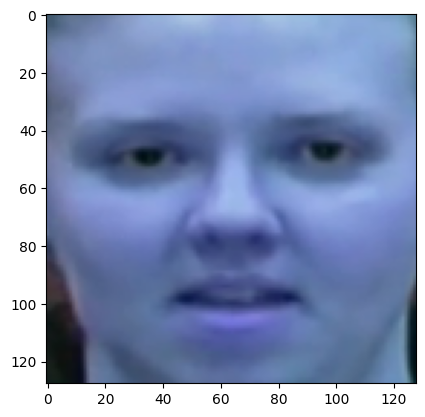

In [11]:
plt.imshow(frames[17])

In [ ]:
# Function to extract frames from video provided by user
def extract_frames(video_path, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    ret, frame = cap.read()
    while ret:
        if frame_count % frame_interval == 0:
            detector = MTCNN()
            faces = detector.detect_faces(frame)
            if len(faces) != 0:
                x, y, width, height = faces[0]['box']
                frame = frame[y:y + height, x:x + width]
                frame = cv2.resize(frame, (128, 128))
                frame = frame / 255.0  # Normalize
                frame = frame.astype(np.float32)
                frames.append(frame)
                print(frame_count)
        ret, frame = cap.read()
        frame_count += 1

    cap.release()
    print(f"Total Frames: {len(frames)}")
    return np.array(frames)

In [33]:
img = cv2.imread(r"20250212_102846.jpg")
detector = MTCNN()
faces = detector.detect_faces(img)
if len(faces) != 0:
    x, y, width, height = faces[0]['box']
    img = img[y:y + height, x:x + width]
img = cv2.resize(img, (128, 128))  # Resize
img = img / 255.0  # Normalize (0-1)
img = img.astype(np.float32)

# Add a batch dimension
img = np.expand_dims(img, axis=0)


predictions = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [34]:
predictions

array([[0.9716592]], dtype=float32)

In [37]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    detector = MTCNN()
    faces = detector.detect_faces(img)
    if len(faces) != 0:
        x, y, width, height = faces[0]['box']
        img = img[y:y + height, x:x + width]
    img = cv2.resize(img, (128, 128))  # Resize
    img = img / 255.0  # Normalize (0-1)
    img = img.astype(np.float32)

    # Add a batch dimension
    img = np.expand_dims(img, axis=0)


    predictions = model.predict(img)
    avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Average Prediction Score: {avg_prediction:.4f}")
    print(f"Final Classification: {"Fake" if avg_prediction < 0.5 else "Real"}")

In [38]:
predict_image(r"20250212_102846.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Average Prediction Score: 0.9717
Final Classification: Real


In [ ]:
def predict_video(video_path):
    frames = extract_frames(video_path)
    predictions = model.predict(frames , batch_size=2)  # Get predictions for each frame

    avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Average Prediction Score: {avg_prediction:.4f}")

    # If avg_prediction > 0.5, classify as Fake; else, Real
    video_label = "Fake" if avg_prediction > 0.5 else "Real"
    print(f"Final Video Classification: {video_label}")

In [29]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  # Resize
    img = img / 255.0  # Normalize (0-1)
    img = img.astype(np.float32)

    # Add a batch dimension
    img = np.expand_dims(img, axis=0)


    predictions = model.predict(img)
    avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Average Prediction Score: {avg_prediction:.4f}")
    print(f"Final Classification: {"Fake" if avg_prediction > 0.5 else "Real"}")

In [5]:
def input_path(type, path):
    if type == "v" or "V":
        predict_video(path)
    elif type == "i" or "I":
        predict_image(path)
    else:
        print("Invalid Input")

In [31]:
count = 0
for i in os.listdir(r"celebdf+ff++\test\real"):
    img = cv2.imread(os.path.join(r"celebdf+ff++\test\real", i))
    img = img / 255.0
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    if pred < 0.5:
        print("real")
        count += 1
print(count)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

In [32]:
count = 0
for i in os.listdir(r"celebdf+ff++\test\fake"):
    img = cv2.imread(os.path.join(r"celebdf+ff++\test\fake", i))
    img = img / 255.0
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    if pred < 0.5:
        print("real")
        count += 1
print(count)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/ste

In [6]:
type = input("Enter the type of input (v for video, i for image): ")
path = input("Enter the path of the video/image: ")
input_path(type,path)

NameError: name 'extract_frames' is not defined

In [ ]:
IMG = frames[0]
plt.imshow(IMG)

In [ ]:
pred = []
for i in os.listdir(r"celebdf+ff++\validation\fake"):
    IMG = np.expand_dims(IMG, axis=0)
    predictions = model.predict(IMG)
    pred.append(predictions)
    # avg_prediction = np.mean(pred)  # Average across all frames
    # print(f"Average Prediction Score: {avg_prediction:.4f}")
    # print(f"Final Classification: {"Fake" if avg_prediction > 0.5 else "Real"}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
